#### **Introduction**

At the end of the year, each Spotify user is sent "Your Top Songs of year" playlist, including the top 100 songs you have been listening the most in that year, calculated based on the number of play count. I understand this method. It is intuitive, but I wonder if there's another method to create a similar playlist. Then I come up with an idea: the playlist of the songs you play repeatedly the most.

**Let's define some basic terms**
- A __*replayed  song*__ is a song that are played repeatedly, not interrupted by another song.

    *For example, here is my Spotify streaming history in a working day. The replayed songs were A and D. The songs B, C, E, F were not replayed.*

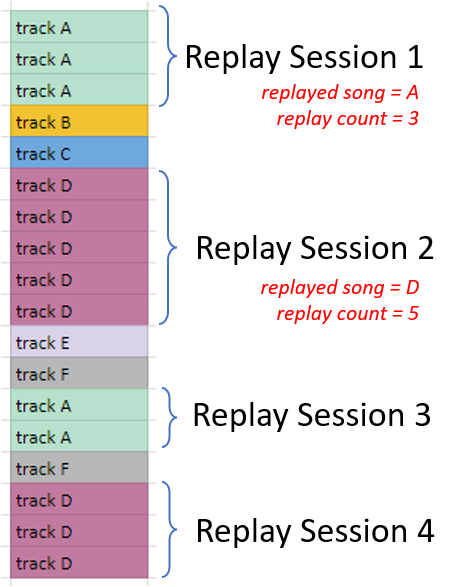


- A __*replay session*__ contains a unique song that got replayed. A replay session starts when I starts to replay that song, and end when I move on the other song.

    *In the above example, I had 4 replay sessions, 2 for song A, 2 for song D.*

- __*Replay count*__ is the number of times a song is replayed in a replay session.

    *In the first session, the replay count of song A is 3.*

**Why am I interested in songs that got replayed?**

- You won't replay a song that you don't like.
- If you repeatedly play a song, i.e. for 10, 20 times straight, it'll highly be a song you love, at least for that short period of time.
- I know that a lot of people have the habit of binge listening when they find a song they like. They keep playing that song, again and again, maybe until they become bored with the song. The replay sessions they made with the song might not help the song to be included in the Spotify "Your Top Songs" but the song probably says something about them, thus it should not be ignored.

The playlist "Your Replayed songs" will contain the songs that you like or at least, you used to like. In other words, a playlist of the songs you are binge listening or used to be binge listening. I believe it's worth listening to them again.

In this article, I will use my personal streaming history. The time range is "all time" - since I started to use Spotify.



In [2]:
import pandas as pd
import json
import re
from datetime import datetime
import pytz
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import spotipy
import os
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv


#### **Questions I'll find the answer**

1. How many songs that are 'replayed songs'? And distribution of the replay count?
2. Find TOP 30 songs that have the most replay counts
3. Find TOP 30 songs that have the most replay sessions
4. Find TOP replayed songs by merging two above lists, then create a Spotify playlist containing all these songs
5. TOP 10 artists has the most replayed songs
6. In which part of the day I would highly replay a song?

#### **Step 1: Raw file merging**

After I make a request for the all-time streaming history, I received a link to download the history file (in json type). My streaming history is divided into a few json files, so I need to merge them into a single file.

I'll use python built-in module "glob" to search for the json files based on the pattern of the names.

In [3]:
merged_json = []
for jsonFile in glob.glob('streaming_history\*.json'): # search for all json files from the directory
    with open(jsonFile, 'rb') as file: 
        x = json.load(file)
        merged_json+= x

to_json_file = json.dumps(merged_json) # convert merged_json to a json type object, so that we can convert it into a dataframe
df = pd.read_json(to_json_file) # now we have the dataframe we need

#### **Step 2: Data Transformation**

**Step 2.1: Choose columns to keep**

a) Choose columns to keep

In [4]:
for i, name in enumerate(df.columns):
    print(f"{i} ---> {name}")

0 ---> ts
1 ---> username
2 ---> platform
3 ---> ms_played
4 ---> conn_country
5 ---> ip_addr_decrypted
6 ---> user_agent_decrypted
7 ---> master_metadata_track_name
8 ---> master_metadata_album_artist_name
9 ---> master_metadata_album_album_name
10 ---> spotify_track_uri
11 ---> episode_name
12 ---> episode_show_name
13 ---> spotify_episode_uri
14 ---> reason_start
15 ---> reason_end
16 ---> shuffle
17 ---> skipped
18 ---> offline
19 ---> offline_timestamp
20 ---> incognito_mode


In [5]:
keep_col = [0,3,7,8,9,10] # Columns to keep
df = df.iloc[:, keep_col]

b) Rename the columns

In [6]:
df = df.rename(columns={
    'master_metadata_track_name': 'track_name',
    'master_metadata_album_artist_name': 'artist_name',
    'master_metadata_album_album_name': 'album_name'
})

**Step 2.2: Look at null values and drop them if necessary**

In [7]:
# check for the null values
df.isnull().sum()

ts                      0
ms_played               0
track_name           1532
artist_name          1532
album_name           1532
spotify_track_uri    1532
dtype: int64

In [8]:
# keep the row where track_name is not null
df = df[df['track_name'].notna()]

**Step 2.3: Sort the table by the timestamp column then reset the index**

In [9]:
# Change the timezone of 'timestamp' column from Zulu time to GMT+7
df['timestamp'] = pd.to_datetime(df['ts'])
df['timestamp'] = df['timestamp'].dt.tz_convert('Asia/Ho_Chi_Minh')
df['date'] = df['timestamp'].dt.date
df['time'] = df['timestamp'].dt.time

df = df.drop(['ts'], axis=1) # drop the 'ts' column

# sort the table based on 'timestamp' column
df = df.sort_values(by='timestamp', ascending=True, ignore_index=True)

#### **Step 3: Aggregate the data**


Now I'm looking for the replay sessions.

In [10]:
df['next_track'] = df['spotify_track_uri'].shift(-1)

df['will_be_replay'] = np.select(
    [df['spotify_track_uri'] == df['next_track']],
    [True]
)


In [11]:
x = 0 # variable số lần replay thứ bao nhiêu trong 1 session. Nếu bài hát không nằm trong 1 replay session thì x = 0.
result = [] # list chứa biến x, sau này dùng để add vào df

ses = 1 # variable số thứ tự của replay session. Nếu bài hát khồng nằm trong 1 replay session thì ses is null.
session = [] # list chứa biến ses, sau này dùng để add vào df

for i in df.index:
    c = df.will_be_replay[i]
    if i == 0:
        p1 = 0
    else:
        p1 = df.will_be_replay[i-1]

    if c == 0 and p1 == 0:
        x = 0
        result.append(x)
    elif p1 == 1:
        x += 1
        result.append(x)
    elif c == 1 and p1 == 0:
        x = 1
        result.append(x)
    
df['cummulative_replay'] = pd.Series(result)

for j in df.index:
    c = df.will_be_replay[j]
    if j == 0:
        p1 = 0
    elif j > 0:
        p1 = df.will_be_replay[j-1]

    if c == 0 and p1 == 0:
        session.append(np.nan)
    elif c == 1 and p1 == 0:
        ses += 1
        session.append(ses)
    else:
        session.append(ses)

df['replay_session'] = pd.Series(session)

Until this, we have found the replay sessions. We'll create the pivot table to calculate: 

| Column name | Explanation | Example |
| --- | --- | --- |
| start_time | When the session begins (in HH:mm:ss) | I started to replay "Happy New Year" by ABBA from 16:44:47 |
| start_date | When the session begins (in YYYY-MM-DD) | The session began in 2016-12-10 |
| start_weekday | The weekday of the start_date | The session began in Saturday |
| replay_count | How many times the song are replayed in the session | I would play this song 30 times consecutively before I played another song |
| duration |  How long the session will last (in HH:mm:ss) | The session of 30 times playing "Happy New Year" last for 92 minutes, 23 seconds |


In [12]:
replay = pd.pivot_table(
    data = df.loc[:, ['track_name', 'artist_name', 'album_name','spotify_track_uri', 'replay_session', 'cummulative_replay', 'timestamp', 'ms_played']],
    index = ['track_name', 'artist_name', 'album_name','spotify_track_uri', 'replay_session'],
    values = ['timestamp','cummulative_replay', 'ms_played'],
    aggfunc= {'timestamp': 'min', 'cummulative_replay': 'max', 'ms_played': 'sum'}
)

replay.columns = ['replay_count', 'duration', 'start_timestamp'] # rename the calculated columns
replay['duration'] = pd.to_datetime(replay['duration'], unit='ms').dt.strftime('%H:%M:%S') # convert the duration of session in the format of HH:mm:ss
replay = replay.reset_index()

replay['start_date'] = replay['start_timestamp'].dt.date
replay['start_time'] = replay['start_timestamp'].dt.time
replay['start_hour'] = replay['start_timestamp'].dt.hour
replay['start_weekday'] = replay['start_timestamp'].dt.strftime('%A')
replay = replay.drop(['start_timestamp'], axis=1)

Because a song can be unwillingly replayed for some reasons, I will only consider the replay session with the replay count >= 3.

In [13]:
replay = replay[replay.replay_count >= 3].reset_index(drop=True)

#### **Step 4: Answer the questions**

**1. How many songs that are 'replayed songs'? And distribution of the replay count?**

In [14]:
replay.replay_count.describe().reset_index()

,index,replay_count
0,count,886.000000
1,mean,9.147856
2,std,20.716042
3,min,3.000000
4,25%,3.000000
5,50%,4.000000
6,75%,8.000000
7,max,520.000000


In [15]:
# count distinct song_id
len(replay.spotify_track_uri.unique())

637

Since I started to use Spotify (stats excluding the sessions with the replay count <= 2):
- I had 886 replay sessions. 
- Max replay count of a session = 520.
- There are 637 unique songs appearing in a replay session.

The distribution of replay count is highly right-skewed, thus the mean value of replay count (which is 9.14) is not valuable.

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


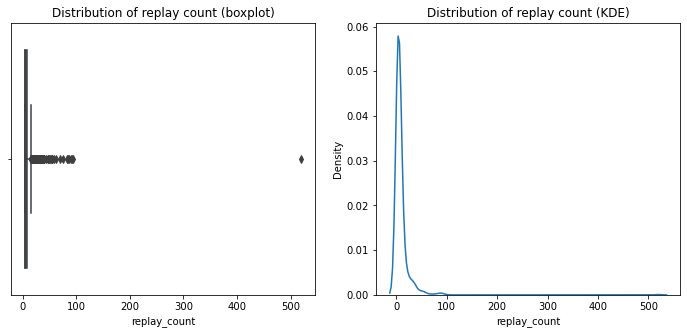

In [16]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1 = sns.boxplot(
    replay.replay_count,
    ax = ax1,
    orient='h'
)
# ax1.set_yticks(np.arange(0,600,50))
ax1.set_title('Distribution of replay count (boxplot)')

sns.kdeplot(
    replay.replay_count,
    ax = ax2
)
ax2.set_title('Distribution of replay count (KDE)')
plt.show()

Because we don't have a lot of distinct values for replay_count per a session, we should look at all the values to see the distribution.

In [26]:
# replay.replay_count.value_counts().reset_index().sort_values(by='replay_count', acsending=False)
replay.replay_count.value_counts().sort_index()

3      336
4      139
5       81
6       46
7       32
8       35
9       26
10      24
11      16
12      16
13      10
14       4
15      12
16       8
17       7
18       2
19       4
20       1
21       5
22       7
23       6
24       1
25       5
26       2
27       3
28       3
29       2
30       1
31       4
32       3
33       2
34       6
35       3
36       3
37       3
38       2
39       3
44       1
46       3
47       1
49       1
51       1
52       1
54       2
55       2
58       1
62       1
69       1
75       1
83       1
84       1
86       1
90       1
91       1
94       1
520      1
Name: replay_count, dtype: int64

The highest occurence is of course 3. The number of replay count in a session is often below 16.  Replay counts above 25 are quite rare. There is only one single session with replay count above 100, and surprisingly, I replayed a song 520 times in that session.

Let's look at that 520-session.

In [27]:
replay[replay.replay_count == 520]

,track_name,artist_name,album_name,spotify_track_uri,replay_session,replay_count,duration,start_date,start_time,start_hour,start_weekday
48,Alone At Last,mellow fox,Take A Break,spotify:track:2nOnnz6eVIR9WaehoRbNwS,3919.0,520,09:05:36,2023-08-02,09:00:38,9,Wednesday


It happened recently, on 2023-08-02. It was a normal working day. I replayed the song since the start of working hour (9:00) till the working day ended (18:05). Just a song for the entire day. And guess what, 520 times playing consecutively didn't help the song to be in my "Your Top Songs 2023" created by Spotify.

**2. TOP 30 songs that have the most replay counts**

First I'll create the table 'groupby_song', then it's easy to filter the top songs by 'total_replay_count' or 'no_session'.

In [28]:
# count(distinct session) and sum(replay_count) group by song
groupby_song = pd.pivot_table(
    data=replay.loc[:, ['spotify_track_uri', 'track_name', 'artist_name','replay_session','replay_count']],
    index = ['spotify_track_uri', 'track_name', 'artist_name'],
    values= ['replay_session','replay_count'],
    aggfunc= {'replay_session': 'count','replay_count': 'sum'}
)

groupby_song.columns = ['total_replay_count', 'no_session']
groupby_song = groupby_song.reset_index()

In [29]:
# TOP 30 songs by replay counts
top30_replaycount = groupby_song.sort_values(by='total_replay_count', ascending=False, ignore_index=True).head(30)

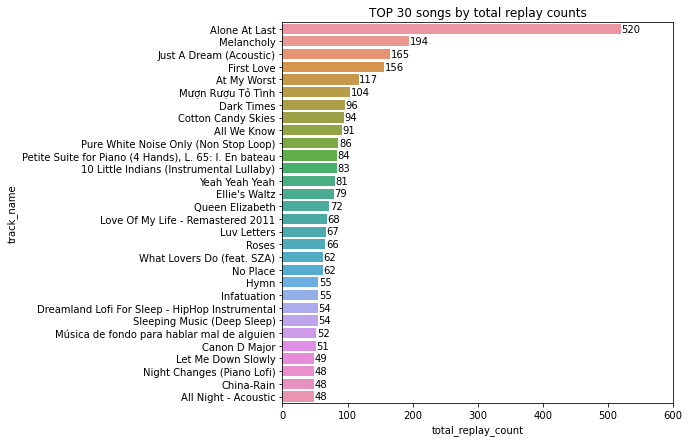

In [30]:
ax = sns.barplot(
    data = top30_replaycount,
    y = 'track_name',
    x = 'total_replay_count'
)
# change figsize
fig = plt.gcf()
fig.set_size_inches(7,7)

# set title and change xticks
ax.set_xticks(np.arange(0,top30_replaycount.total_replay_count.max() + 100,100))
ax.set_title('TOP 30 songs by total replay counts')

# add data table
for i in range(len(top30_replaycount)):
    plt.text(top30_replaycount.total_replay_count[i] + 1, i, top30_replaycount.total_replay_count[i], va = 'center')
plt.show()

**3. TOP 30 songs that have the most replay sessions**

In [31]:
top30_no_session = groupby_song.sort_values(by=['no_session', 'total_replay_count'], ascending=False, ignore_index=True).head(30)

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21345 (\N{CJK UNIFIED IDEOGRAPH-5361}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 36786 (\N{CJK UNIFIED IDEOGRAPH-8FB2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 37628 (\N{CJK UNIFIED IDEOGRAPH-92FC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 29748 (\N{CJK UNIFIED IDEOGRAPH-7434}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from current font.
  fig.canvas.print_figure(bytes_

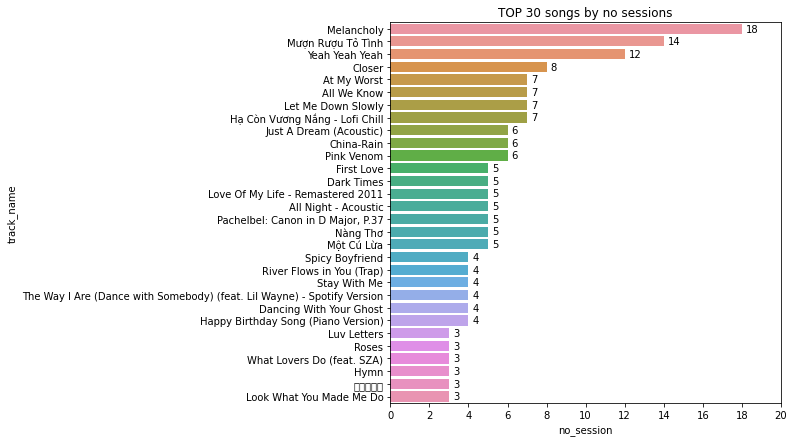

In [32]:
ax = sns.barplot(
    data = top30_no_session,
    y = 'track_name',
    x = 'no_session'
)
# change figsize
fig = plt.gcf()
fig.set_size_inches(7,7)

# set title and change xticks
ax.set_xticks(np.arange(0,top30_no_session.no_session.max() + 3,2))
ax.set_title('TOP 30 songs by no sessions')

# add data label
for i in range(len(top30_no_session)):
    plt.text(top30_no_session.no_session[i] + 0.2, i, top30_no_session.no_session[i], va = 'center')
plt.show()

**4. Find TOP replayed songs by merging two above lists, then create a Spotify playlist containing all these songs**

In [33]:
# my final top replayed songs
top_replay_song = pd.concat([top30_replaycount, top30_no_session]).drop_duplicates().reset_index().drop(['index'], axis=1)

In [35]:
# Create an empty playlist and add the songs to it
load_dotenv()
scope = 'playlist-modify-public'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))
results = sp.user_playlist_create(user='taominh127', name=f'My Top Replayed Songs', description='This is a playlist created by Python.')
new_playlist = sp.user_playlists(user='taominh127', limit=1)
playlist_id = new_playlist['items'][0]['id']
sp.playlist_add_items(playlist_id=playlist_id, items=top_replay_song.spotify_track_uri)

{'snapshot_id': 'MyxmZmE3MDAwNzMzN2JjMzNhOGZjMjI3YjI5YmU4Zjg4MWZiZTdjZmM5'}

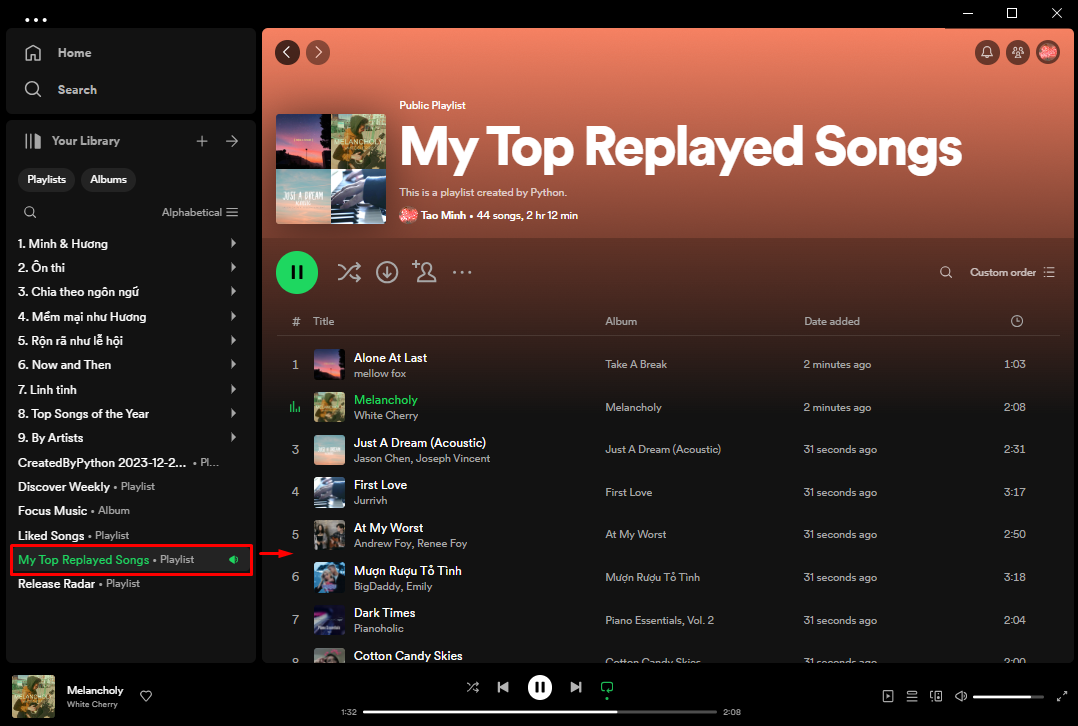
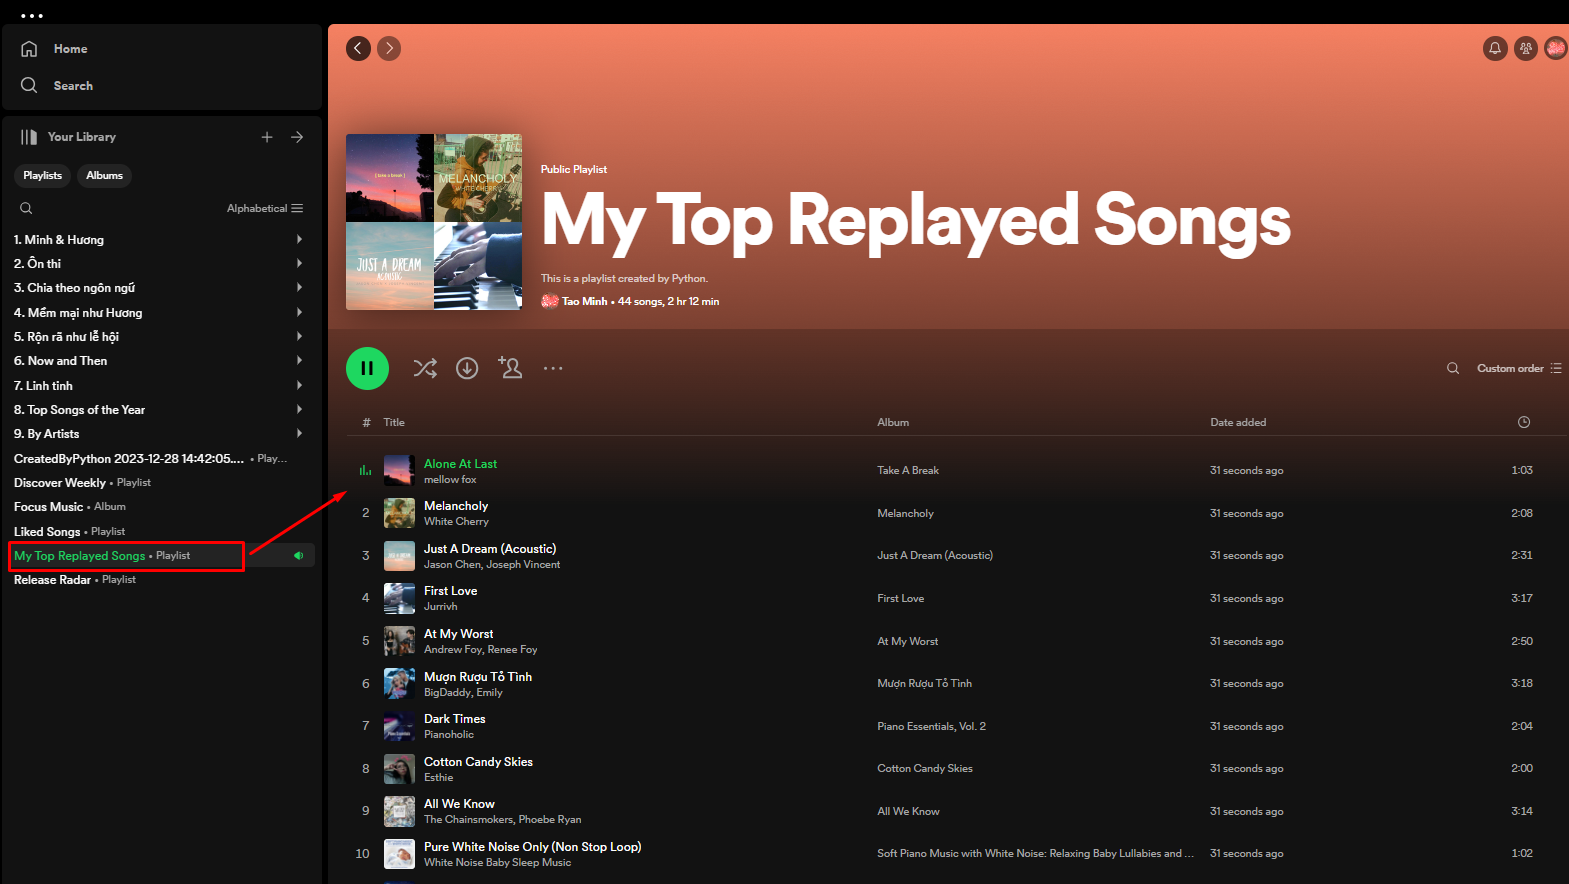

**5. TOP 5 artists has the most replayed songs**

Based on the table: groupby_song

In [ ]:
pd.set_option('display.max_colwidth', None)
groupby_artist = pd.pivot_table(
    data= groupby_song.loc[:, ['artist_name', 'spotify_track_uri', 'track_name', 'no_session', 'total_replay_count']],
    index = ['artist_name'],
    values = ['spotify_track_uri','no_session', 'total_replay_count', 'track_name'],
    aggfunc = {'spotify_track_uri': 'nunique', 'no_session': 'sum', 'total_replay_count':'sum','track_name': lambda x: ' | '.join(x)}
)
groupby_artist.columns = ['no_session', 'no_tracks', 'total_replay_count', 'track_list'] # change the column names
groupby_artist = groupby_artist.reindex(['no_tracks', 'no_session', 'total_replay_count','track_list'], axis=1).reset_index() # re-order the columns
top_artists = groupby_artist.sort_values(by='no_tracks', ascending=False, ignore_index=True).head(10) # LIMIT 10
top_artists

,artist_name,no_tracks,no_session,total_replay_count,track_list
0,Đen,7,11,48,Lối Nhỏ | Lối Nhỏ | Rapcoustic 5 | Bài Này Chill Phết | Trốn Tìm | Mang Tiền Về Cho Mẹ | Luôn yêu đời
1,Guus Dielissen,6,6,92,Dance Monkey (Instrumental Guitar) | Canon In D - Guitar Version | Dance Monkey (Instrumental Guitar) | Canon In D - Guitar Version | River Flows In You - Guitar Version | My Heart Will Go On - Acoustic Instrumental
2,Sasha Alex Sloan,6,9,53,Matter To You | Dancing With Your Ghost | Dancing With Your Ghost | Older | when was it over? (feat. Sam Hunt) | Runaway
3,Queen,6,10,85,Love Of My Life | Love Of My Life - Remastered 2011 | Somebody To Love - Remastered 2011 | Bohemian Rhapsody - Remastered 2011 | We Will Rock You - Remastered 2011 | Crazy Little Thing Called Love - Remastered 2011
4,Sungha Jung,6,7,56,River Flows In You | I'm Yours | Wake Me up When September Ends | Etude | May Be | Is There Still Anything That Love Can Do?
5,Karmin,6,6,66,Sleigh Ride | Sugar | Save Me Now | I Got You | Along The Road | Didn't Know You
6,The Chainsmokers,4,19,207,All We Know | Roses | Closer | Inside Out
7,Akon,4,5,19,Don't Matter | Lonely | Blown Away | Lonely
8,Music Travel Love,4,6,26,You Are My Sunshine | I Don't Want to Miss a Thing | True Colors (Live at Singha Park) | One More Day
9,Taylor Swift,4,7,51,champagne problems | Look What You Made Me Do | A Place In This World | 22


**6. In which part of the day I would highly replay a song?**

Let's count the replay session by the start hour.

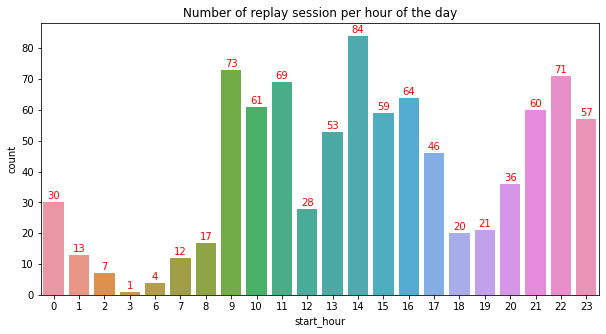

In [ ]:
ax = sns.countplot(
    data=replay,
    x = 'start_hour'
)
ax.set_title('Number of replay session per hour of the day')
fig = plt.gcf()
fig.set_size_inches(10,5)

# add data label
for x, y in enumerate(replay.start_hour.value_counts().sort_index().values):
    plt.text(x, y + 1, y, ha = 'center', c = 'r')

Surprisingly I had some replay sessions at 1AM, 2AM, 3AM, 6AM. I never had replay sessions at 4AM, 5AM (who is awake at that time?). The sessions occured through out the day but they are less often when the hour is 7, 8, 12 (outside the working hours) or 18, 19, 20 (when I commute and have dinner).